# First Approach to a univariate Long-Short-Term Memory model for predicting the solar output  #

For our optimisation we need solar output predictions. In this notebook we will use a univariate Long-Short-Term Memory model to predict the solar output. 


 https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM


First install all the dependencies:

In [14]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import permutations

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout, LSTM , Conv1D, MaxPooling1D  # create layers


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle
 
np.random.seed(42)
tf.random.set_seed(42)


We will start with loading the pickle file with our full dataset into this notebook. 



In [2]:
df = pd.read_pickle("../data/final_dataframe.pkl")

The column names are not very easy to work with and can be a bit hard to read. Therefore we will rename them to make them easier to read.

In [3]:
def col_names(df):
    ''' this function renames the columns to make them easier to read 
      additionally set the date as index in our dataframe'''
    column_names = {'Photovoltaics [MWh] Original resolutions': 'Solar_generation_MWh',
                'Photovoltaics [MW] Calculated resolutions': 'Solar_installed_MW',
                'Total (grid load) [MWh] Original resolutions': 'Total_consumption_MWh',
                'Germany/Luxembourg [€/MWh] Calculated resolutions': 'DE_LU_price_per_MWh',}
    df.rename(columns=column_names, inplace=True)
    #df.set_index('Date', inplace=True)
    return df

col_names(df)


,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
0,2018-10-01 00:00:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
1,2018-10-01 00:15:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
2,2018-10-01 00:30:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
3,2018-10-01 00:45:00,0.0,42805.0,10589.75,59.53,0.684015,0.0
4,2018-10-01 01:00:00,0.0,42805.0,10589.75,56.10,0.684015,0.0
...,...,...,...,...,...,...,...
163675,2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.000000,0.0
163676,2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.000000,0.0
163677,2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.000000,0.0
163678,2023-06-01 23:30:00,0.0,62579.0,12371.00,86.53,1.000000,0.0


Now we can already split the data into train and test set. Important to note here is that the shuffle has to be false otherwise the split is not appropriate for time series analysis. I will use the previously defined approach from the 20230704_train_val_test_split notebook 

In [114]:
# I have a huge problem with the 0 therfore I will add 1 to all my datapoints 
#df['Solar_generation_MWh_normalized'] = df['Solar_generation_MWh_normalized'] + 1

In [6]:
target = ['Date', 'Solar_generation_MWh_normalized']

In [7]:
def test_train_timeseries(df, target):
    ''' In the first part we select the train and test data.
    In the second per the columns we want to use for our predictions '''
    
    test = df[df.Date >= '2022-06-01']
    train = df[df.Date < '2022-06-01']

    # now we select the columns we want to use for our predictions

    test = test[target]
    train = train[target]
    return test, train

test, train = test_train_timeseries(df, target)

In [117]:
#Alternatively we could also use 
#train, test = train_test_split(df[['Solar_generation_MWh_normalized']], test_size=.25, shuffle=False)

I worked nicely

In [12]:
#Scale the data for the model #! Test MinMaxScaler 

scalable = ['Solar_generation_MWh_normalized']

scaler = StandardScaler()
train[scalable] = scaler.fit_transform(train[scalable])
test[scalable] = scaler.transform(test[scalable])

In [15]:
with open('../models/solar_scaler.pkl','wb') as f:
    pickle.dump(scaler, f)

In [16]:
test

,Date,Solar_generation_MWh_normalized
128544,2022-06-01 00:00:00,-0.638367
128545,2022-06-01 00:15:00,-0.638367
128546,2022-06-01 00:30:00,-0.638367
128547,2022-06-01 00:45:00,-0.638367
128548,2022-06-01 01:00:00,-0.638367
...,...,...
163675,2023-06-01 22:45:00,-0.638367
163676,2023-06-01 23:00:00,-0.638367
163677,2023-06-01 23:15:00,-0.638367
163678,2023-06-01 23:30:00,-0.638367


In [17]:
# split a univariate sequence into samller samples to feed into the LSTM
def split_sequence(input, n_steps, pred_size, target = []):
    ''' This function will split our timeseries into supervised timeseries snipets. 
    input = dataframe to be split
    n_steps = length of the X_variable 
    pred_size = length of the y_variable
    features = list of targets to be split
    At the same time we will collect the corresponding timestamps in two additional arrays '''
    input_array = input[target]
    date_array = input['Date']

    x_index, y_index = list(), list()
    x, y = list(), list()
    for i in range(len(input_array)):
        end_ix = i + n_steps # find the end of this pattern
        if end_ix+pred_size > len(input)-1: # check if we are beyond the sequence
            break
        seq_x, seq_y = input_array[i:end_ix], input_array[end_ix: end_ix+pred_size]# gather input and output parts of the pattern
        ind_x, ind_y = date_array[i:end_ix], date_array[end_ix: end_ix+pred_size]# gather input and output Dates of the pattern
        x.append(seq_x)
        y.append(seq_y)
        x_index.append(ind_x)
        y_index.append(ind_y)

    
    return np.array(x), np.squeeze(np.array(y)), np.array(x_index), np.squeeze(np.array(y_index)) 

In [18]:
# define input sequence
input = train
# choose a number of time steps
n_steps = 672
# prediction size 
pred_size= 96

target = ['Solar_generation_MWh_normalized']

# split into samples
X, y, X_train_index, Y_train_index = split_sequence(input, n_steps, pred_size, target)
# summarize the data
print(len(X), len(y))


127776 127776


In [19]:
print(X.shape, y.shape)

print(X_train_index.shape, Y_train_index.shape)

(127776, 672, 1) (127776, 96)
(127776, 672) (127776, 96)


In [20]:
X_test, y_test, X_test_index, Y_test_index = split_sequence(test , n_steps, pred_size, target)

In [21]:
print(X_test.shape, y_test.shape)

print(X_test_index.shape, Y_test_index.shape)

(34368, 672, 1) (34368, 96)
(34368, 672) (34368, 96)


In [22]:
#Now we have to define the validation set for our model #! I see this approach is not so useful, therefore I will use the train test split with shuffling to obtain the validation data. Here i am not loosing the lateest data for training my model 
def val_set(X,y):
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X, X_val, y, y_val
    #! old approach
    #train_size = round(len(X) * 0.8)
    #X = X[:train_size, :]
    #X_val = X[train_size:, :]
    #y = y[:train_size, :]
    #y_val = y[train_size:, :]
    
X, X_val, y, y_val = val_set(X, y)

In [23]:
y_val.shape

(25556, 96)

In [24]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
 #! correction still necessary

def reshape_for_LSTM(X, y, features):
    features
    X = X.reshape((X.shape[0], X.shape[1], features))
    y = y.reshape((y.shape[0], y.shape[1]))
    return X, y

In [25]:
X, y = reshape_for_LSTM(X, y, 1)

In [26]:
X_val, y_val = reshape_for_LSTM(X_val, y_val, 1)

In [27]:
X_test, y_test = reshape_for_LSTM(X_test, y_test, 1)

In [28]:
X_val.shape

(25556, 672, 1)

In [29]:
X.shape

(102220, 672, 1)

## Now we can import our pretrained model ##



In [30]:
simple_LSTM = tf.keras.models.load_model('../models/saved_model/complex_univariate_LSTM')

In [32]:
scores = simple_LSTM.evaluate(X, y)

3195/3195 [==============================] - 101s 32ms/step - loss: 0.1048 - mean_absolute_percentage_error: 130.6040


In [33]:
print("\n%s: %.2f%%" % (simple_LSTM.metrics_names[1], scores[1]))


mean_absolute_percentage_error: 130.60%


In [34]:
#x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
y_pred = simple_LSTM.predict(X_test, verbose=0)
print(y_pred)

[[-0.6523228  -0.63978577 -0.65357035 ... -0.6497922  -0.66473603
  -0.66672194]
 [-0.63802636 -0.6232557  -0.63961583 ... -0.6356775  -0.64848006
  -0.6516876 ]
 [-0.62573946 -0.61052805 -0.6285246  ... -0.6226535  -0.6339941
  -0.63806105]
 ...
 [-0.55609566 -0.55650437 -0.5509321  ... -0.5408409  -0.57819206
  -0.55683106]
 [-0.55727655 -0.5530295  -0.5488323  ... -0.5468478  -0.5851385
  -0.5659196 ]
 [-0.5551415  -0.5463371  -0.5423428  ... -0.5504939  -0.5880582
  -0.56969965]]


In [35]:
print("Evaluate on test data")
results = simple_LSTM.evaluate(X_test, y_test, batch_size=2600)
print("test loss, test MAPE:", results)

Evaluate on test data
14/14 [==============================] - 20s 1s/step - loss: 0.1040 - mean_absolute_percentage_error: 99.2835
test loss, test MAPE: [0.10403409600257874, 99.2835464477539]


## Make a new timeseries from out predicted values so we can plot them nicely

Here i will try hiracical indexing to make a table with all the predictions 

In [58]:
#combi_dict = dict(zip(("Y_test_index", "y_test", "y_pred"), (Y_test_index, y_test, y_pred)))

In [41]:
def make_plotting_table(y_test, y_pred, Y_test_index, time=1):
    inversed_y_test = scaler.inverse_transform(y_test)
    inversed_y_pred = scaler.inverse_transform(y_pred)
    inversed_y_test = pd.DataFrame(inversed_y_test[time-1:time, :].T, columns=['true'])
    Date = pd.DataFrame(Y_test_index[time-1:time, :].T, columns=['Date'])
    inversed_y_pred = pd.DataFrame(inversed_y_pred[time-1:time, :].T, columns=['predicted'])
    df_date = Date
    df_3 = pd.concat([df_date, inversed_y_test], axis=1)
    df_plotting = pd.concat([df_3, inversed_y_pred] ,axis=1)
    df_melted = df_plotting.melt(id_vars = 'Date', value_vars=['predicted', 'true'], var_name = 'Variable', value_name = "Value")
    df_melted["Date"] = pd.to_datetime(df_melted['Date'])
    return df_melted

In [42]:
df_plotting = make_plotting_table(y_test, y_pred, Y_test_index, 2)

In [43]:
df_plotting['hour']= pd.to_datetime(df_plotting['Date']).dt.time

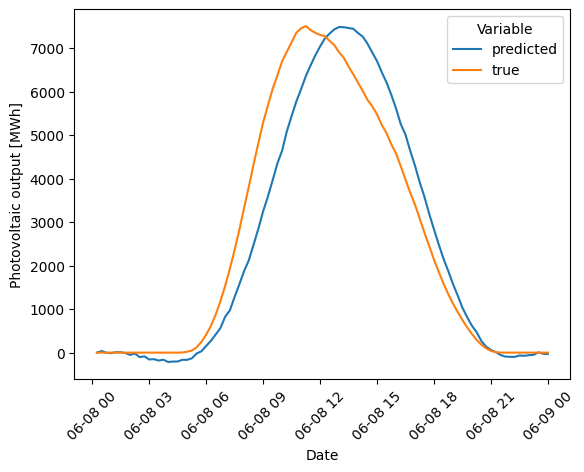

In [44]:
sns.lineplot(data=df_plotting, x ='Date' , y = 'Value', hue = 'Variable')
plt.xticks(rotation=45)
plt.ylabel('Photovoltaic output [MWh]')
plt.show()

The results are getting better. The daily seasonality is taken care of the main problem seems to be the summer winter seasonality. This could be tackled by using the weather data and/ or including the lag feature or weekday-month feature

### Let's now create a proper output table which can then be used for the Optimisation ###
Now we will transform out output back into the same units as before and add them to a dataframe. 

In [131]:
def reverse_and_frame(X, y, X_test_index, Y_test_index):
    ''' The input are both our arrays X_test and the predicted y and the date index of the original X_test array.
    Arguments: X = the original X_test set 
             y = the predicted y set
             X_test = the original index of X_test

    Returns: a dataframe containing the date of the prediction (last day of X_test input)
            the original X-test set 
            the predicted values for y destandardized


     1st. Inverse transfrom the arrays to the original dimensions needed by the optimizer 
     2nd. Create a dataframe for both x_test and y_pred 
     3rd. Merge all the columns representing the timesteps into a single array in one column 
     4th. Create an empty dataframe and add the last date of X_test_index as the timepoint from which the prediction started
     5th  Concatenate the two dataframes into one 
    '''
    #1
    inversed_y_pred = scaler.inverse_transform(y)
    inversed_X_test = scaler.inverse_transform(X.reshape(X.shape[0], X.shape[1]))

    #2
    X_test = pd.DataFrame(inversed_X_test)
    X_index_df = pd.DataFrame(X_test_index)
    y_pred = pd.DataFrame(inversed_y_pred)
    y_index = pd.DataFrame(Y_test_index)


    #3
    X_test['input_array'] = X_test.apply(lambda row: np.array(row), axis=1)
    X_index_df['input_Timestamp'] = X_index_df.apply(lambda row: np.array(row), axis=1)
    y_pred['output_array'] = y_pred.apply(lambda row: np.array(row), axis=1)
    y_index['output_Timestamp'] = y_index.apply(lambda row: np.array(row), axis=1)

    #4
    df_final = pd.DataFrame((X_test_index[:, -1]), columns=["Prediction_date"] )
    #df_final["Prediction_date"]= X_test_index[:, -1]

    #5
    df_final['output_Timestamp'] = y_index['output_Timestamp']
    df_final['solar_output'] = y_pred['output_array']
    df_final['input_Timestamp'] = X_index_df['input_Timestamp']
    df_final['input'] = X_test['input_array']
    return df_final

In [132]:
solar_predictions= reverse_and_frame(X_test, y_pred, X_test_index, Y_test_index)

In [126]:
solar_predictions

,Prediction_date,solar_output_Timestamp,solar_output,input_Timestamp,input
0,2022-06-07 23:45:00,"[2022-06-08T00:00:00.000000000, 2022-06-08T00:...","[-34.365818, -3.4939919, -37.43784, -44.094578...","[2022-06-01T00:00:00.000000000, 2022-06-01T00:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-06-08 00:00:00,"[2022-06-08T00:15:00.000000000, 2022-06-08T00:...","[0.8384055, 37.21023, -3.0755348, -10.384129, ...","[2022-06-01T00:15:00.000000000, 2022-06-01T00:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-06-08 00:15:00,"[2022-06-08T00:30:00.000000000, 2022-06-08T00:...","[31.094265, 68.551414, 24.235989, 17.597195, 2...","[2022-06-01T00:30:00.000000000, 2022-06-01T00:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-06-08 00:30:00,"[2022-06-08T00:45:00.000000000, 2022-06-08T01:...","[49.1896, 81.6072, 34.844387, 31.252102, 27.43...","[2022-06-01T00:45:00.000000000, 2022-06-01T01:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-06-08 00:45:00,"[2022-06-08T01:00:00.000000000, 2022-06-08T01:...","[50.31155, 72.22805, 24.090237, 25.812527, 15....","[2022-06-01T01:00:00.000000000, 2022-06-01T01:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
34363,2023-05-31 22:30:00,"[2023-05-31T22:45:00.000000000, 2023-05-31T23:...","[199.38834, 172.90335, 196.73026, 205.83707, 1...","[2023-05-24T22:45:00.000000000, 2023-05-24T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34364,2023-05-31 22:45:00,"[2023-05-31T23:00:00.000000000, 2023-05-31T23:...","[203.53067, 190.33963, 209.444, 219.77213, 213...","[2023-05-24T23:00:00.000000000, 2023-05-24T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34365,2023-05-31 23:00:00,"[2023-05-31T23:15:00.000000000, 2023-05-31T23:...","[202.58804, 201.5817, 215.30301, 225.01126, 23...","[2023-05-24T23:15:00.000000000, 2023-05-24T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34366,2023-05-31 23:15:00,"[2023-05-31T23:30:00.000000000, 2023-05-31T23:...","[199.6802, 210.13846, 220.47366, 230.7786, 254...","[2023-05-24T23:30:00.000000000, 2023-05-24T23:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [133]:
df_solar_predictions = solar_predictions[['Prediction_date', 'output_Timestamp', 'solar_output',]].copy()

### Import the predicted consumption values from the LSTM_consumption and add the predicitons to the final predictions df 

In [134]:
df_consumption = pd.read_pickle('../predictions/consumption_predictions.pkl')

In [135]:
df_solar_predictions['consumption_output'] = df_consumption['consumption_output']

In [79]:
#df_solar_predictions.to_pickle("../predictions/predictions_full.pkl")
#df_solar_predictions.to_json("../predictions/solar_predictions_all.json")

### Include the price into the final df ##

In [83]:
#the the original df
df_1 = df[df['Date'] >= '2022-06-07 23:45:00']
df_1

,Date,Solar_generation_MWh,Solar_installed_MW,Total_consumption_MWh,DE_LU_price_per_MWh,normalisation_factor,Solar_generation_MWh_normalized
129215,2022-06-07 23:45:00,0.0,58002.0,11732.50,210.97,0.92686,0.0
129216,2022-06-08 00:00:00,0.0,58002.0,11515.00,185.05,0.92686,0.0
129217,2022-06-08 00:15:00,0.0,58002.0,11342.75,185.05,0.92686,0.0
129218,2022-06-08 00:30:00,0.0,58002.0,11236.50,185.05,0.92686,0.0
129219,2022-06-08 00:45:00,0.0,58002.0,11139.25,185.05,0.92686,0.0
...,...,...,...,...,...,...,...
163675,2023-06-01 22:45:00,0.0,62579.0,12945.50,95.41,1.00000,0.0
163676,2023-06-01 23:00:00,0.0,62579.0,12817.75,86.53,1.00000,0.0
163677,2023-06-01 23:15:00,0.0,62579.0,12539.00,86.53,1.00000,0.0
163678,2023-06-01 23:30:00,0.0,62579.0,12371.00,86.53,1.00000,0.0


In [143]:
def make_price_sequence(df):
            list_1 = []
            for i in range(len(df["DE_LU_price_per_MWh"])):
                k = np.array(df.iloc[i : i+96, 4].astype(float))
                list_1.append(k)
            df_1 = pd.DataFrame(list_1)
            pred = df_1.apply(lambda row: np.array(row), axis=1)
            return pred


In [118]:
#testing_df = make_price_sequence(df)

In [120]:
#dF_wtf = pd.DataFrame(testing_df)
#dF_wtf.apply(lambda row: np.array(row), axis=1)

In [144]:
df_solar_predictions['price_output'] = make_price_sequence(df)

In [145]:
df_solar_predictions.isnull().sum()

Prediction_date       0
output_Timestamp      0
solar_output          0
consumption_output    0
price_output          0
dtype: int64

In [138]:
df_solar_predictions.to_pickle("../predictions/predictions_full.pkl")
#df_solar_predictions.to_json("../predictions/solar_predictions_all.json")